In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Defining function to load gpx data into dataframe with some processing using the harvesine equation
import gpxpy
import pandas as pd
from haversine import haversine
import matplotlib.pyplot as plt
import numpy as np

def gpx_to_dataframe(file_name):
    """
    Parses a GPX file and returns a Pandas DataFrame with extracted data.
    
    Args:
        file_name (str): The path to the GPX file.
        
    Returns:
        pd.DataFrame: A DataFrame containing latitude, longitude, elevation, time,
                      and other optional GPX fields.
    """
    # Open and parse the GPX file
    with open(file_name, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)

    # Extract data from tracks (you can also extract waypoints, routes, etc.)
    data = []
    for track in gpx.tracks:
        for segment in track.segments:
            print('Points to read:',len(segment.points))
            for i, point in enumerate(segment.points):
                
                if i==0:
                    prev_point = point
                    dist_delta = 0
                    total_dist = 0
                else:
                    dist_delta = haversine(
                        (prev_point.latitude, prev_point.longitude),
                        (point.latitude, point.longitude)
                    )
                    # Overwriting prev_point for next iteration loop
                    prev_point = point 
                    total_dist = data[-1]['total_distance'] + dist_delta

                data.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'elevation': point.elevation,
                    'total_distance': total_dist,
                    'distance_delta': dist_delta
                })

    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Calculate grade
    df['grade'] = (df['elevation'].diff()/df['distance_delta']/10).clip(upper=100, lower=-100)
    window_size = 5
    df['grade_MA'] = df['grade'].rolling(window=window_size).apply(
        lambda x: weighted_moving_average(x, df['distance_delta'].iloc[x.index]), raw=False)

    
    # Calculate totals
    df['total_elevation_gain'] = df['elevation'].diff().cumsum()
    df['total_ascent'] = df['elevation'].diff().clip(lower=0).cumsum()
    df['total_descent'] = df['elevation'].diff().clip(upper=0).cumsum()*(-1)
    df.fillna(0, inplace = True)
    
    return df

# Example usage:
# df = gpx_to_dataframe('your_file.gpx')
# print(df.head())

# Calculate the weighted moving average
def weighted_moving_average(x, weights):
    return (x * weights).sum() / weights.sum()


# Function to convert decimal time to mm:ss format
def decimal_to_mm_ss(decimal_time):
    total_seconds = decimal_time * 60  # Convert minutes to total seconds
    minutes, seconds = divmod(total_seconds, 60)  # Get minutes and seconds
    return f"{int(minutes):02d}:{int(seconds):02d}"  # Format as mm:ss

# Function to convert decimal time to hh:mm:ss format
def decimal_to_hh_mm_ss(decimal_time):
    total_seconds = decimal_time * 60  # Convert minutes to total seconds
    hours, minutes_tmp = divmod(total_seconds, 3600)
    minutes, seconds = divmod(minutes_tmp, 60)  # Get minutes and seconds
    return f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"  # Format as hh:mm:ss


def downsample_full_gpx(df_full, bin_size_km):
    cols = ['total_distance','elevation','total_ascent','total_descent']
    df_out = pd.DataFrame(columns = cols)
    bin_vec = np.unique(df_full.total_distance - (df_full.total_distance % bin_size_km))
    bin_vec = np.append(bin_vec, df_full['total_distance'].max().round(1))

    for i in bin_vec:
        idx_tmp = abs(df_full['total_distance']-i).idxmin()
        tmp = df_full.loc[idx_tmp,cols]      
        df_out = pd.concat([df_out, pd.DataFrame([tmp])], ignore_index = True)
        

    df_out['grade'] = df_out['elevation'].diff()/(bin_size_km*1000)*100
    df_out = df_out.round(1)
    df_out.fillna(0, inplace = True)
    return df_out

# Here calculate elevation gain and loss for each KM and check predicted split times with same method as bining
def full_df_to_km_splits(df_full, target_GAP):
    cols = ['total_distance','total_ascent','total_descent']
    df_km_splits = pd.DataFrame(columns = cols)


    split_kms = df_full['total_distance'].round().unique()

    if split_kms[-1:] < df_full['total_distance'].max():
        split_kms = np.append(split_kms,df_full['total_distance'].max().round(1))

    # Loop to get closest km indices
    for i in split_kms:
        idx_tmp = abs(df_full['total_distance']-i).idxmin()
        tmp = df_full.loc[idx_tmp,cols]
        df_km_splits = pd.concat([df_km_splits, pd.DataFrame([tmp])], ignore_index = True)

    df_km_splits['total_distance'] = df_km_splits['total_distance'].round(1)
    df_km_splits['split_ascent'] = df_km_splits['total_ascent'].diff()
    df_km_splits['split_descent'] = df_km_splits['total_descent'].diff()
    df_km_splits = df_km_splits.drop(index=0)
    

    # Calculate predicted split time
    df_km_splits['target_pace'] = (1+df_km_splits['split_ascent']/100)*target_GAP
    df_km_splits['target_pace_mm_ss'] = df_km_splits['target_pace'].apply(decimal_to_mm_ss)

    # Calculate total time --> Work-around for last element required
    df_km_splits['total_time'] = df_km_splits['target_pace'].cumsum()
    df_km_splits.loc[df_km_splits.index[-1],'total_time'] = (df_km_splits['target_pace'].tail(1).iloc[0]
                              *round(df_km_splits['total_distance'].max() % 1,1)
                              +df_km_splits['total_time'].tail(2).iloc[0])
    df_km_splits['total_time_hh_mm_ss'] = df_km_splits['total_time'].apply(decimal_to_hh_mm_ss)

    return df_km_splits

In [14]:
df_full_Mozart = gpx_to_dataframe('gpx_files/mozart100_MARATHON_2025.gpx')
df_full_Mozart = gpx_to_dataframe("gpx_files/COURSE_351116202.gpx")

Points to read: 1734
Points to read: 1101


In [15]:
target_GAP = 5.0 # min/km
df_splits_Roses = full_df_to_km_splits(df_full_Roses, target_GAP)
df_splits_Mozart = full_df_to_km_splits(df_full_Mozart, target_GAP)

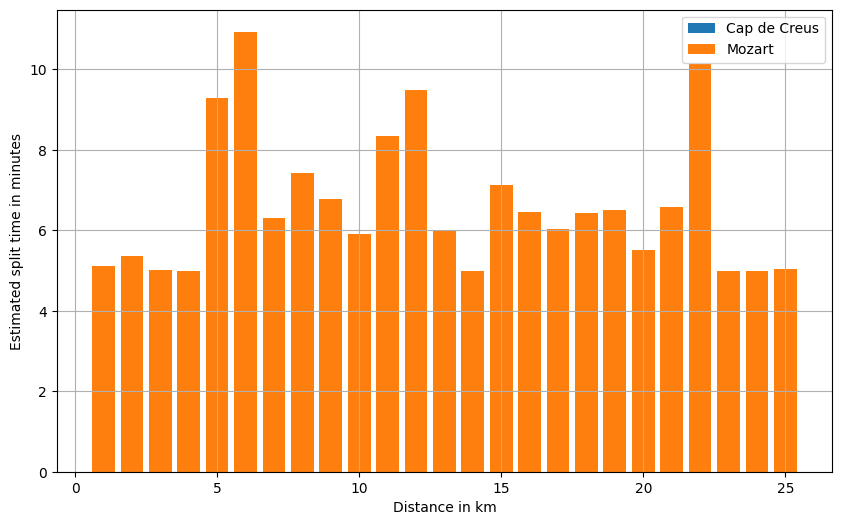

In [16]:

plt.figure(figsize=(10,6))
plt.bar(df_splits_Roses.total_distance, df_splits_Roses.target_pace)
plt.bar(df_splits_Mozart.total_distance, df_splits_Mozart.target_pace)
plt.grid(True)
plt.xlabel('Distance in km')
plt.ylabel('Estimated split time in minutes')
plt.legend(['Cap de Creus','Mozart'])
plt.show()

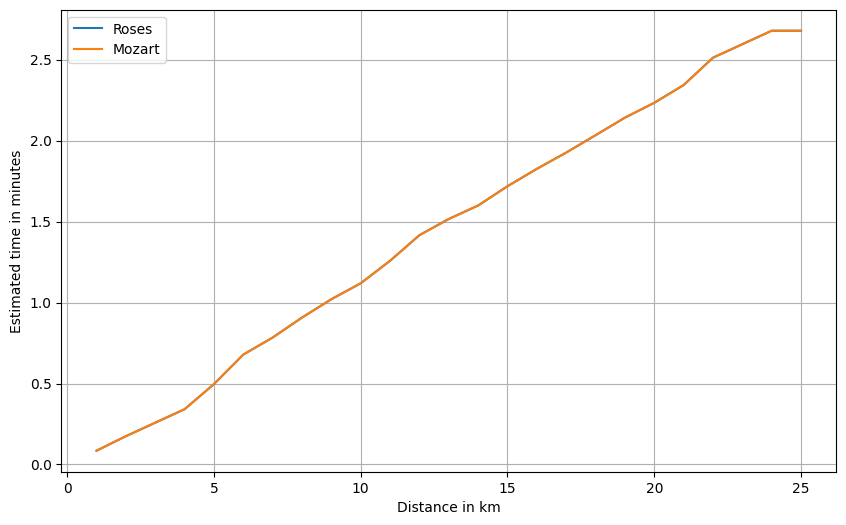

In [17]:
plt.figure(figsize=(10,6))
plt.plot(df_splits_Roses.total_distance, df_splits_Roses.total_time/60)
plt.plot(df_splits_Mozart.total_distance, df_splits_Mozart.total_time/60)
plt.grid(True)
plt.xlabel('Distance in km')
plt.ylabel('Estimated time in minutes')
plt.legend(['Roses','Mozart'])
plt.show()

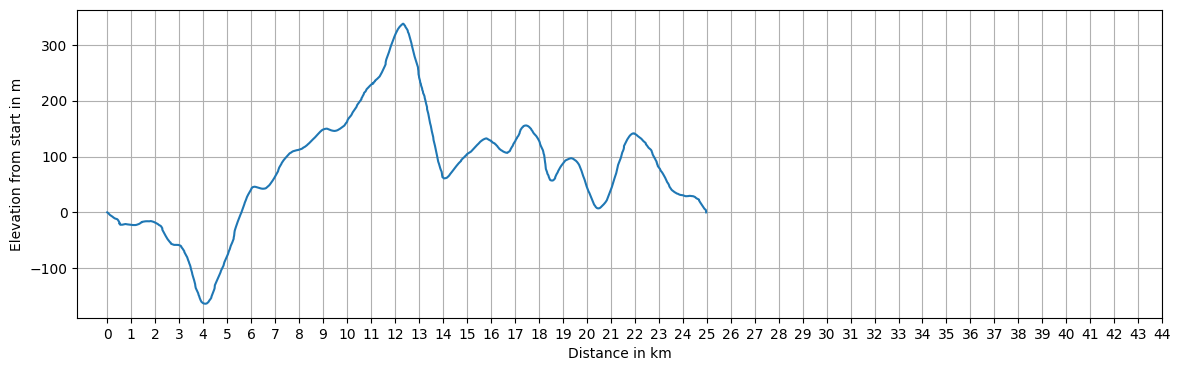

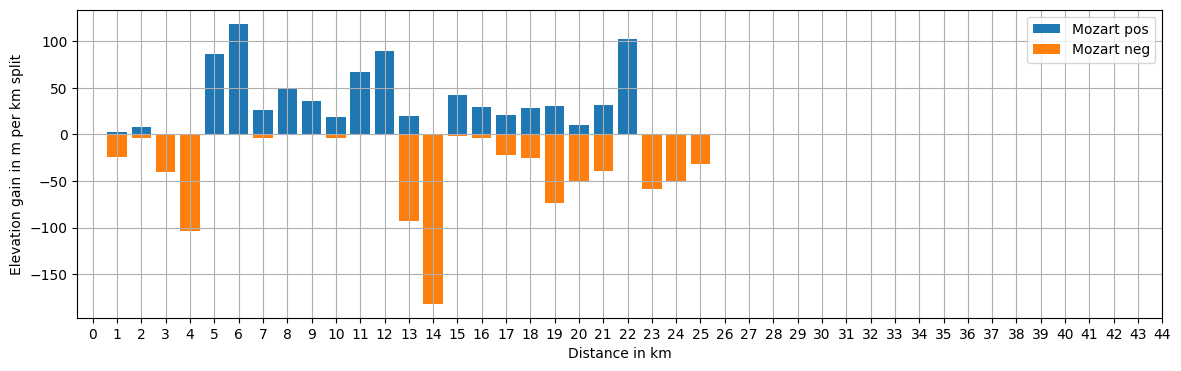

In [18]:
plt.figure(figsize=(14,4))
#plt.plot(df_full_Roses.total_distance, df_full_Roses.total_elevation_gain)
plt.plot(df_full_Mozart.total_distance, df_full_Mozart.total_elevation_gain)
plt.grid(True)
plt.xlabel('Distance in km')
plt.ylabel('Elevation from start in m')
#plt.legend(['Roses','Mozart'])
x_ticks = list(range(0,45,1))
plt.xticks(x_ticks)
plt.show()

plt.figure(figsize=(14,4))
plt.bar(df_splits_Mozart.total_distance, df_splits_Mozart.split_ascent)
plt.bar(df_splits_Mozart.total_distance, -df_splits_Mozart.split_descent)
#plt.bar(df_splits_T50.total_distance, df_splits_T50.split_ascent)
plt.grid(True)
plt.xlabel('Distance in km')
plt.ylabel('Elevation gain in m per km split')
x_ticks = list(range(0,45,1))
plt.xticks(x_ticks)
plt.legend(['Mozart pos','Mozart neg'])
plt.show()

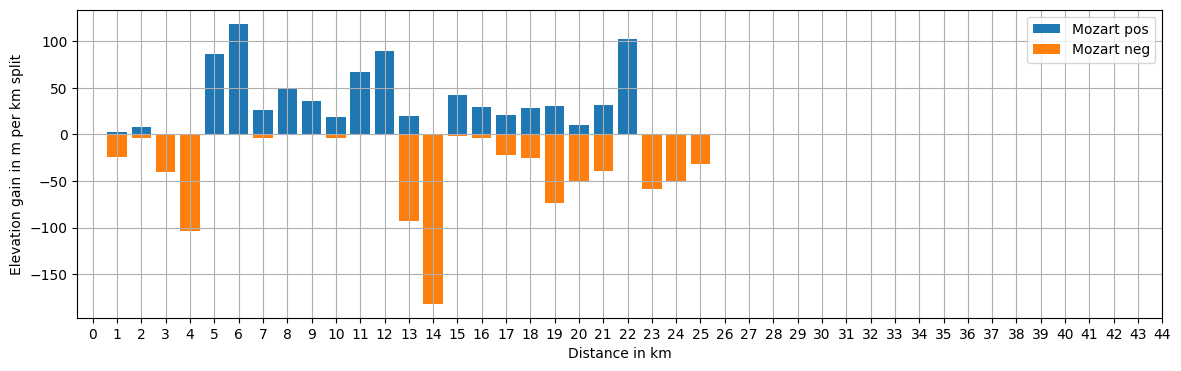

In [19]:
plt.figure(figsize=(14,4))
plt.bar(df_splits_Mozart.total_distance, df_splits_Mozart.split_ascent)
plt.bar(df_splits_Mozart.total_distance, -df_splits_Mozart.split_descent)
#plt.bar(df_splits_T50.total_distance, df_splits_T50.split_ascent)
plt.grid(True)
plt.xlabel('Distance in km')
plt.ylabel('Elevation gain in m per km split')
x_ticks = list(range(0,45,1))
plt.xticks(x_ticks)
plt.legend(['Mozart pos','Mozart neg'])
plt.show()

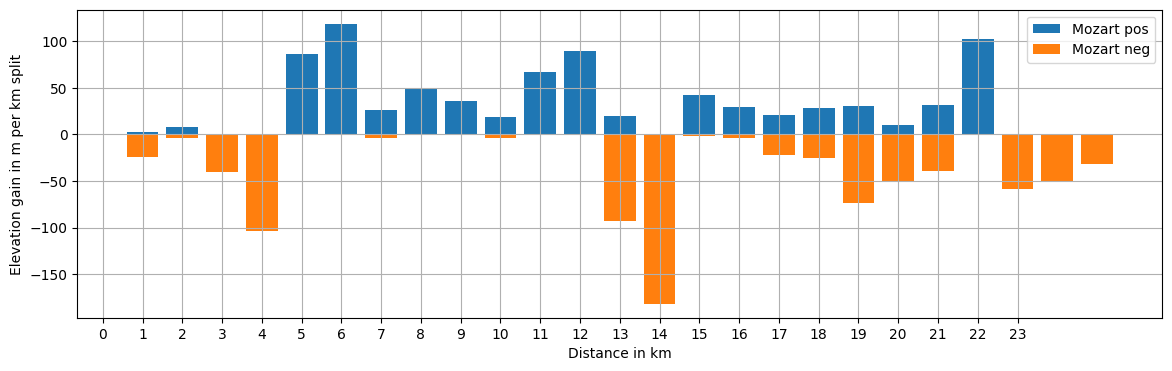

In [20]:
plt.figure(figsize=(14,4))
plt.bar(df_splits_Roses.total_distance, df_splits_Roses.split_ascent)
plt.bar(df_splits_Roses.total_distance, -df_splits_Roses.split_descent)
#plt.bar(df_splits_T50.total_distance, df_splits_T50.split_ascent)
plt.grid(True)
plt.xlabel('Distance in km')
plt.ylabel('Elevation gain in m per km split')
x_ticks = list(range(0,24,1))
plt.xticks(x_ticks)
plt.legend(['Mozart pos','Mozart neg'])
plt.show()

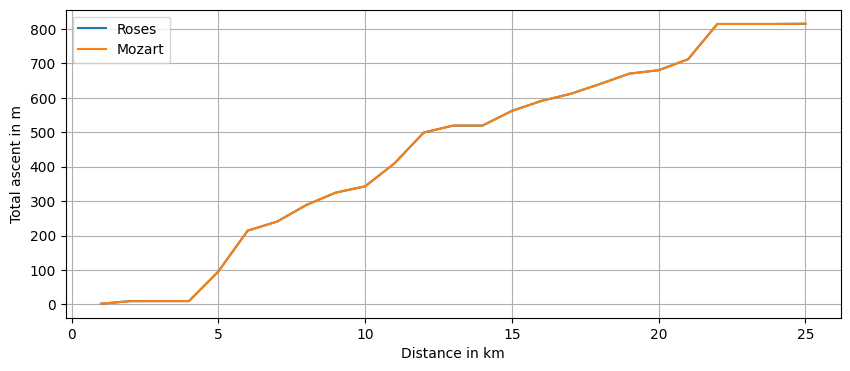

In [21]:
plt.figure(figsize=(10,4))
plt.plot(df_splits_Roses.total_distance, df_splits_Roses.total_ascent)
plt.plot(df_splits_Mozart.total_distance, df_splits_Mozart.total_ascent)
plt.grid(True)
plt.xlabel('Distance in km')
plt.ylabel('Total ascent in m')
plt.legend(['Roses','Mozart'])
plt.show()

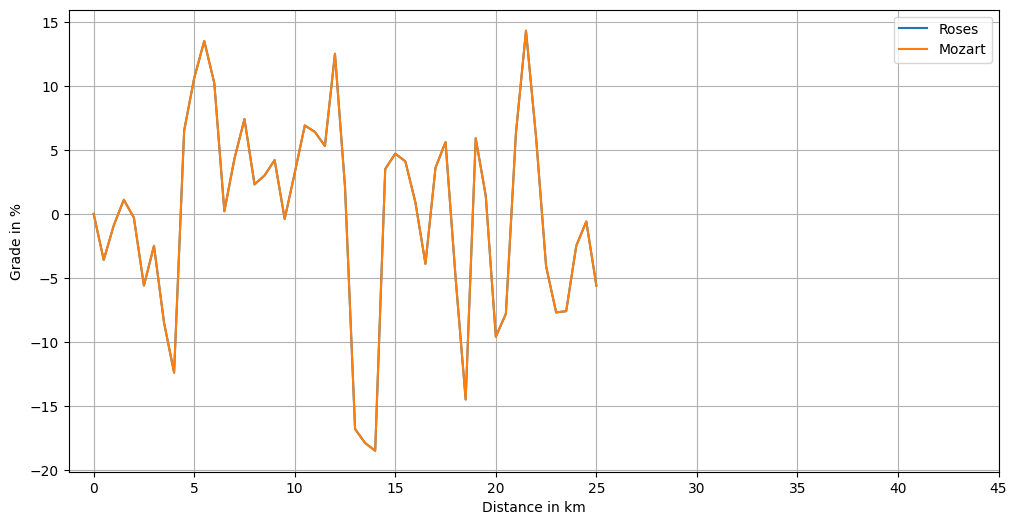

In [22]:
#plot grade profile differences downsampled
bin_size = 0.5

df_Roses_grade = downsample_full_gpx(df_full_Roses, bin_size)
df_Mozart_grade = downsample_full_gpx(df_full_Mozart, bin_size)

plt.figure(figsize=(12,6))
plt.plot(df_Roses_grade['total_distance'],df_Roses_grade['grade'])
plt.plot(df_Mozart_grade['total_distance'],df_Mozart_grade['grade'])
plt.grid(True)
plt.xlabel('Distance in km')
plt.ylabel('Grade in %')
plt.legend(['Roses','Mozart'])
ticks = list(range(0,50,5))
plt.xticks(ticks)
plt.show()

In [23]:
# Add grade based colouring
from matplotlib.collections import LineCollection

# Sample data
x = df_LaLlanera_grade['total_distance']
y = df_LaLlanera_grade['elevation']
color_values = df_LaLlanera_grade['grade']  # Let's color based on the `y` values

# Create line segments
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection with segments and map color_values to it
lc = LineCollection(segments, cmap='jet', norm=plt.Normalize(color_values.min(), color_values.max()))
lc.set_array(color_values)  # Sets the array to color by
lc.set_linewidth(2)  # Line width

# Plot
fig, ax = plt.subplots(figsize = (14,5))
ax.add_collection(lc)
ax.set_xlim(x.min(), x.max()*1.02)
ax.set_ylim(y.min(), y.max()*1.02)

# Add a color bar to show the mapping of colors
plt.grid(True)
plt.colorbar(lc, ax=ax, label='Grade [%]')

plt.show()


NameError: name 'df_LaLlanera_grade' is not defined